In [93]:
import pandas as pd
import utils_function
import numpy as np

In [112]:
site_list = ['KUMC', 'UTSW', 'MCW', 'UofU', 'UIOWA', 'UMHC', 'UPITT', 'UTHSCSA', 'UNMC']

In [115]:
site_list = ['KUMC']

In [116]:
for site in site_list:
    configs_variables = utils_function.read_config(site)
    datafolder = configs_variables['datafolder']
    home_directory = configs_variables['home_directory']  

    basefolder = "/blue/yonghui.wu/hoyinchan/Data/Qi_code_and_data/"

    onset_new = pd.read_pickle(basefolder+"onset_all_"+site+".pkl")

    onset_new['PATID'] = onset_new['PATID'].astype(str)
    onset_new['ENCOUNTERID'] = onset_new['ENCOUNTERID'].astype(str)   
    onset_new['AKI_STAGE']=onset_new['AKI_INIT_STG']
    onset_new = onset_new.drop_duplicates()
    onset_new['SINCE_ADMIT'] = onset_new['ONSET_SINCE_ADMIT']
    onset_new.to_parquet(datafolder+site+'/p0_onset_'+site+'.parquet') 

In [117]:
def count_AKI(onset, new_name, cohort_table=None):
    cohort_table2 = onset[['ENCOUNTERID', 'AKI_STAGE']].groupby('AKI_STAGE').count()
    cohort_table2.rename(columns={'ENCOUNTERID': new_name}, inplace=True)
    # Add a row for the total of stages 1.0, 2.0, and 3.0
    total = cohort_table2.loc[1.0:3.0].sum()
    cohort_table2.loc['Total_AKI'] = total  
    cohort_table2.loc['Total'] = onset.shape[0]
    if cohort_table is not None:
        cohort_table2 = pd.concat([cohort_table, cohort_table2], axis=1)
    return cohort_table2

In [118]:
cohort_table = count_AKI(onset_new, 'Raw_count')

## Create Flow Chart for baseline estimation

In [124]:
flow_chart_dict = {'Total Encounters': 2034996,
 'Total Patients': 1121851,
 'Enc. with 1w SCr': 547952,
 'Enc. without 1w SCr': 1487044,
 'Enc. with 1y SCr': 895473,
 'Enc. without 1y SCr': 591571,
 'Non-CKD Enc. without 1y SCr': 578293,
 'CKD Enc. without 1y SCr': 13278,
 'Total Onset Enc.:': 414622,
 'Total Onset Patients:': 315950,
 'AKI1 Enc.': 270999,
 'AKI2 Enc.': 88052,
 'AKI3 Enc.': 55571}

total_encounters = flow_chart_dict['Total Encounters']
percentage_dict = {
    key: np.round((value / total_encounters * 100),1) if isinstance(value, (int, float)) else value
    for key, value in flow_chart_dict.items()
}
percentage_dict['Total Encounters']=100

import schemdraw
from schemdraw import flow

arl = 2
with schemdraw.Drawing() as d:
    d.config(fontsize=14, unit=0.5)
    # Start terminal
    d += flow.Terminal().label('Estimate SCr baseline').fill('#2296dd')
    # Arrow to decision
    d += flow.Arrow().length(arl).label(f"Encounter number\nn={flow_chart_dict['Total Encounters']:,} ({percentage_dict['Total Encounters']}%)")

    # Decision box
    decision = flow.Decision(E='Yes', S='No', w=5, h=3).label('SCr\nwithin 7 days prior\nto Admission?').fill('#EEE811')
    d += decision  # Add the decision to the drawing    
    # Arrow and square on east
    d += flow.Arrow().right().at(decision.E).length(arl*2.5).label(f"n={flow_chart_dict['Enc. with 1w SCr']:,} ({percentage_dict['Enc. with 1w SCr']}%)", loc='bottom')
    d += flow.Process(w=7.5, h=2).label('min(most recent SCr records\nwith in 7 days prior to admission,\nadmission 24h SCr value)').fill('#48b780')    
    # Arrow and square on south
    d += flow.Arrow().down().at(decision.S).length(arl).label(f"n={flow_chart_dict['Enc. without 1w SCr']:,} ({percentage_dict['Enc. without 1w SCr']}%)")

    # Decision box
    decision = flow.Decision(E='Yes', S='No', w=5, h=3).label('SCr\n7-365 days prior to\nAdmission?').fill('#EEE811')
    d += decision  # Add the decision to the drawing    
    # Arrow and square on east
    d += flow.Arrow().right().at(decision.E).length(arl*2.5).label(f"n={flow_chart_dict['Enc. with 1y SCr']:,} ({percentage_dict['Enc. with 1y SCr']}%)", loc='bottom')
    d += flow.Process(w=7.5, h=2).label('min(mean(most recent SCr records\nwith in 7 days prior to admission),\nadmission 24h SCr value)').fill('#48b780')    
    # Arrow and square on south
    d += flow.Arrow().down().at(decision.S).length(arl).label(f"n={flow_chart_dict['Enc. without 1y SCr']:,} ({percentage_dict['Enc. without 1y SCr']}%)")

    # Decision box
    decision = flow.Decision(E='Yes', S='No', w=5, h=3).label('CKD History?').fill('#EEE811')
    d += decision  # Add the decision to the drawing    
    # Arrow and square on east
    d += flow.Arrow().right().at(decision.E).length(arl*2.5).fill('#EEE811').label(f"n={flow_chart_dict['Non-CKD Enc. without 1y SCr']:,} ({percentage_dict['Non-CKD Enc. without 1y SCr']}%)", loc='bottom')
    d += flow.Process(w=7.5, h=2).label('minSCr estimated by MDRD\nwith 75 mL/min/1.73m\u00b2 eGFR,\nadmission 24h SCr value)').fill('#48b780')    
    # Arrow and square on south
    d += flow.Arrow().down().at(decision.S).length(arl).label(f"n={flow_chart_dict['CKD Enc. without 1y SCr']:,} ({percentage_dict['CKD Enc. without 1y SCr']}%)")
    
    d += flow.Process(w=7, h=2.5).label('Drop encounters with CKD\nhistory if no SCr\nmeasurements can be found\nfrom the last year.').fill('#48b780')
    
    # Show the drawing
    d.draw()
    d.save('scrbaseline.svg')

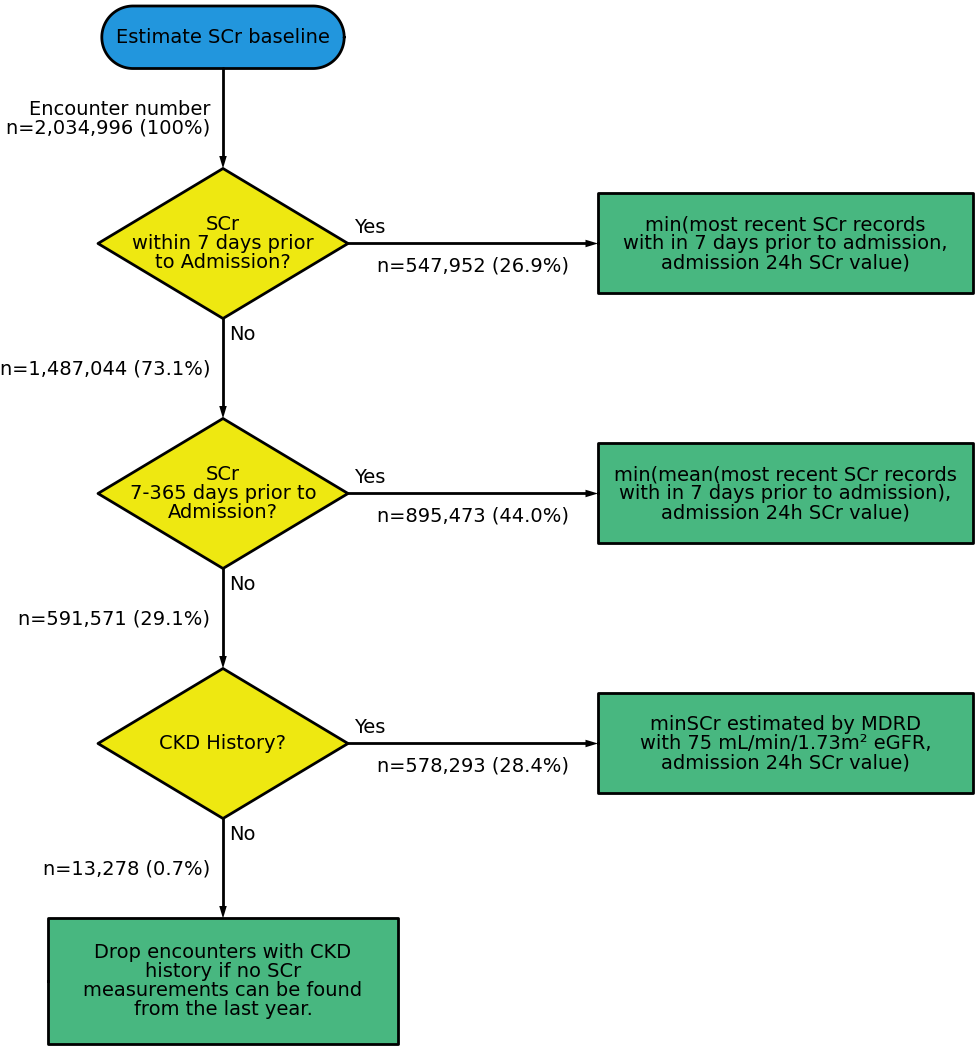

## Feature counts

In [126]:
sites = ['UTHSCSA', 'UTSW', 'MCW', 'UofU', 'UIOWA', 'UMHC', 'UNMC', 'KUMC', 'UPITT']
configs_variables_list = [utils_function.read_config(site) for site in sites]

In [138]:
# Get before and after drop nan
all_columns_pre = dict()
all_columns_drop_nan = dict()

for configs_variables in configs_variables_list:
    
    site, datafolder, home_directory = utils_function.get_commons(configs_variables)    
    
    print(site)

    stg = configs_variables['stg']
    threshold = float(configs_variables['threshold_for_too_much_nan'])

    onset = pd.read_parquet(configs_variables['datafolder']+configs_variables['site']+'/p0_onset_'+configs_variables['site']+'.parquet')
    years = list(pd.to_datetime(onset['ADMIT_DATE']).dt.year.unique())    
    bt_list = list()

    columns_agg = list()
    
    for year in years:
        # try:
        data = pd.read_pickle(datafolder+site+'/bt3_'+site+'_'+str(year)+'.pkl')
        columns_agg.extend(list(data.columns))
    
    bt_all = pd.read_pickle(datafolder+site+'/bt3pos_'+site+'_'+stg+'_3000.pkl')
    
    all_columns_pre[site] = np.unique(columns_agg)
    all_columns_drop_nan[site] = list(bt_all.columns)

UTHSCSA
UTSW
MCW
UofU
UIOWA
UMHC
UNMC
KUMC
UPITT


In [142]:
dict_of_lengths = {key: len(value) for key, value in all_columns_drop_nan.items()}

In [144]:
dict_of_lengths

{'UTHSCSA': 514,
 'UTSW': 3011,
 'MCW': 1016,
 'UofU': 1642,
 'UIOWA': 689,
 'UMHC': 1007,
 'UNMC': 1264,
 'KUMC': 1426,
 'UPITT': 1014}